In [1]:
import numpy as np
from typing import List

import torch
import quairkit as qkit
from quairkit import to_state
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 18

In [4]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

Since this part involve random measurements, we fix one seed to reproduce our plot data. One can uncomment this line to obtain a different but similar result.

In [5]:
# qkit.set_seed(np.random.randint(1e7))
qkit.set_seed(4600285)
qkit.get_seed()

4600285

## Experiment setting

prepare Hamiltonian

In [6]:
num_qubits = 4

H = normalized_heisenberg_hamiltonian(n=num_qubits, factor=1.5, hx=-0.5, hz=0, hxx=-1, hyy=-1, hzz=-1)

In [7]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
ground_state = to_state(eigvecs[:, 0])

print(f'ground state energy = {ground_state_energy}')

ground state energy = -0.5156684612641718


Prepare input state as the four-qubit zero state

In [8]:
phi_state = zero_state(num_qubits)

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.2499999999999997


Prepare evolution operator

In [9]:
U = torch.matrix_exp(-1j * H.matrix)

Define the convergence criteria of the sequence of ground-state energy estimation.

In [10]:
def converge_test(list_data: List[float], list_err: List[float]) -> bool:
    r"""Test for convergence
    
    Args:
        list_data: a list of estimation data
        list_err: a list of estimation error, corresponding to each estimation
    
    Returns:
        a boolean determines whether the estimation sequence converges or not
    
    """
    assert len(list_data) == len(list_err)

    if len(list_data) <= 2:
        return False

    if abs(list_data[-1] - list_data[-2]) > list_err[-1]:
        return False

    return abs(list_data[-2] - list_data[-3]) <= list_err[-2]

## Compute data

In [11]:
tau = 10
deg = 322
B = 0.0025
delta_tau = 4

In [ ]:
guess_lambda = algorithm5(tau, H, phi_state, deg, B)

list_ground_tau, list_E_tau, list_error, list_resource = algorithm1(tau, H, phi_state, guess_lambda, delta_tau, converge_test)

We also provide saved data to save computation time.

In [ ]:
# list_ground_tau, list_E_tau, list_error, list_resource = np.load('data/figure2bc_data.npy')

## Plot

In [14]:
# Font size for labels and titles
fontsize = 18

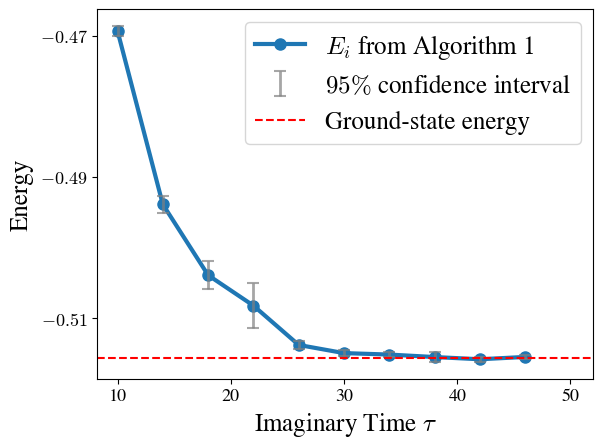

In [15]:
plt.plot(list_ground_tau, list_E_tau, 
         'o-',                  # Circle markers + solid line
         color='C0',            # Main data color
         linewidth=3,           # Line width
         markersize=8,          # Marker size
         label=r'$E_i$ from Algorithm 1')       

plt.errorbar(list_ground_tau, list_E_tau, yerr=list_error, 
             fmt='none',         # No data markers/lines
             ecolor='grey',      # Error bar color
             elinewidth=2,       # Thicker error bars
             capsize=4,          # Cap size for error bars
             capthick=1.5,       # Thicker caps
             alpha=0.7,          # Slight transparency
             label=r'$95\%$ confidence interval')          

plt.axhline(y=ground_state_energy, color='r', linestyle='--', label=r'Ground-state energy')
plt.xlabel(r'Imaginary Time $\tau$', fontsize=fontsize)
plt.ylabel(r'Energy', fontsize=fontsize)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', fontsize=fontsize)
plt.tick_params(labelsize=13)

plt.xticks([10, 20, 30, 40, 50])
ticks = [-0.47, -0.49, -0.51]
plt.yticks(ticks, [f'${tic:.2f}$' for tic in ticks])
plt.xlim(None, 52)

plt.show()

In [16]:
list_ground_error_log = np.log10(np.abs(np.array(list_E_tau) - ground_state_energy))

# 1. linear fit: y = a * x + b
coeffs = np.polyfit(list_resource, list_ground_error_log, 1)
poly_func = np.poly1d(coeffs)

# 2. generate x and y values
x_fit = np.linspace(min(list_resource), max(list_resource), 100)
y_fit = poly_func(x_fit)

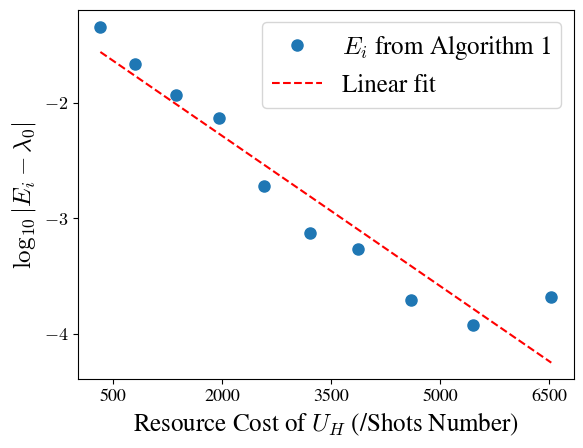

In [17]:
plt.plot(list_resource, list_ground_error_log, 'o', label=r'$E_i$ from Algorithm 1', markersize=8, color='C0')
plt.plot(x_fit, y_fit, '--', label='Linear fit', color='red')

plt.xlabel(r'Resource Cost of $U_H$ (/Shots Number)', fontsize=fontsize)
plt.ylabel(r'$\log_{10}|E_i - \lambda_0|$', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)

plt.xticks([500, 2000, 3500, 5000, 6500])
ticks = [-2, -3, -4]
plt.yticks(ticks, [f'${tic:.0f}$' for tic in ticks])
plt.tick_params(labelsize=13)

plt.show()

---

In [18]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
